In [18]:
import sys
sys.path.append(r'C:\Users\Duy Nguyen\Downloads\UCBerkleyML-AI-TryIts\module 10') # for window
sys.path.append('/Users/ihduynguyen/Downloads/module 10/module') # for mac

In [55]:
import pandas as pd
from UCBerkeley_MLAI.arma.data_process.data_processor import DataProcessor
from UCBerkeley_MLAI.arma.model_selection.model_selector import ModelSelector
from UCBerkeley_MLAI.arma.modelling.arma_fit import ARIMA_fit
from UCBerkeley_MLAI.arma.modelling.sarima_fit import SARIMA_fit
from UCBerkeley_MLAI.arma.forecast.plot_forecaster import Forecaster
from UCBerkeley_MLAI.arma.evaluation.error_analysis import ErrorAnalysis

In [56]:
# train_df = pd.read_csv(r'C:\Users\Duy Nguyen\Downloads\UCBerkleyML-AI-TryIts\module 10\data\rossmann\train.csv', dtype={7: str})
train_df = pd.read_csv(r'C:\Users\Duy Nguyen\Downloads\UCBerkleyML-AI-TryIts\module 10\data\rossmann\train.csv', low_memory=False)
test_df = pd.read_csv(r'C:\Users\Duy Nguyen\Downloads\UCBerkleyML-AI-TryIts\module 10\data\rossmann\test.csv')

In [41]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


### Deal with Duplicate Time Stamps

originally, the data was 1 mil data points. A lot of timestamps has no ascending ordering (time moving forward) which yield:
1. non-monetonic index problem
2. no frequency information meaning we were not sure if the data is daily, month, or yearly.

I decide to aggregate sales with the duplicate time stamps:

##### Train Dataset (Store 1)

In [57]:
store1_df = train_df[train_df['Store'] == 1].copy()

store1_df['Date'] = pd.to_datetime(store1_df['Date'])
store1_df.set_index('Date', inplace=True)
store1_df.sort_index(inplace=True)

sales_series_store1 = store1_df['Sales']


##### Test Dataset

#### Check Stationarity

Note: the adfuller(autolag='AIC') - I used 

Results of Dickey-Fuller Test on Training Series:
Test Statistic                  -4.368104
p-value                          0.000338
#Lags Used                      21.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64


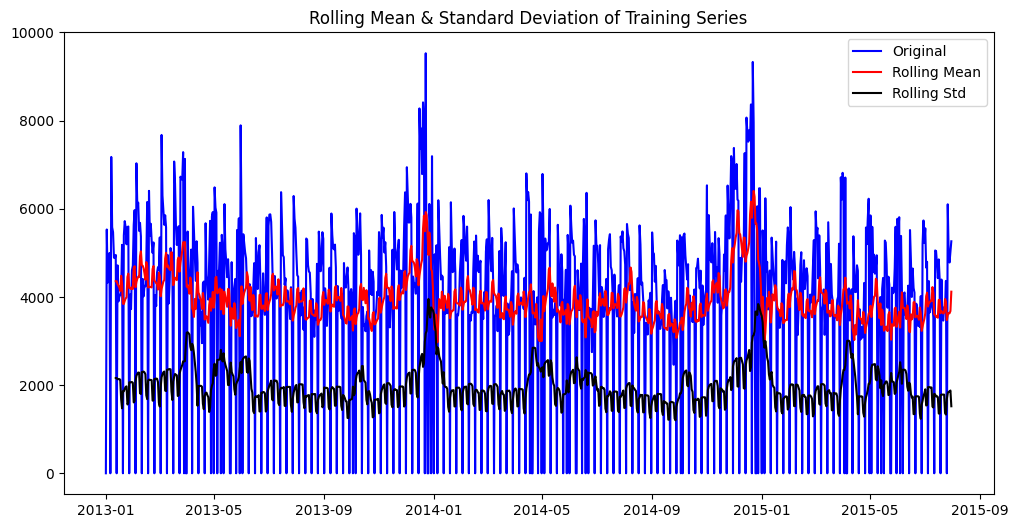

In [109]:
processor = DataProcessor(sales_series_store1, maxlag=None)
if not processor.test_stationarity(): # either way the process.test_stationary() will print
    processor.make_stationary()

1. as you can see the adfuller p-value < 0.05
2. rolling mean and std seems to stay constant
3. confidence levels (1%, 5%, 10%) test statistic is below the critical value 1%

With these three requirement, I am safe to say that the series is stationary. However, it would be cautious to perform decomposition to further confirm that the series is stationary.
- To be cautious, as you can see there seems to be a slight variation every one year. (2014-01 and 2015-01)
- Again, through visual, I can't tell for sure but decomposition is required for confirmation.

#### ACF and PACF
Let's observe to see what is the optimal p and q for AR and MA


In [61]:
# Split the data into training and holdout sets
split_point = int(len(sales_series_store1) * 0.8)  # 80% for training
train_series, test_series = sales_series_store1[:split_point], sales_series_store1[split_point:]

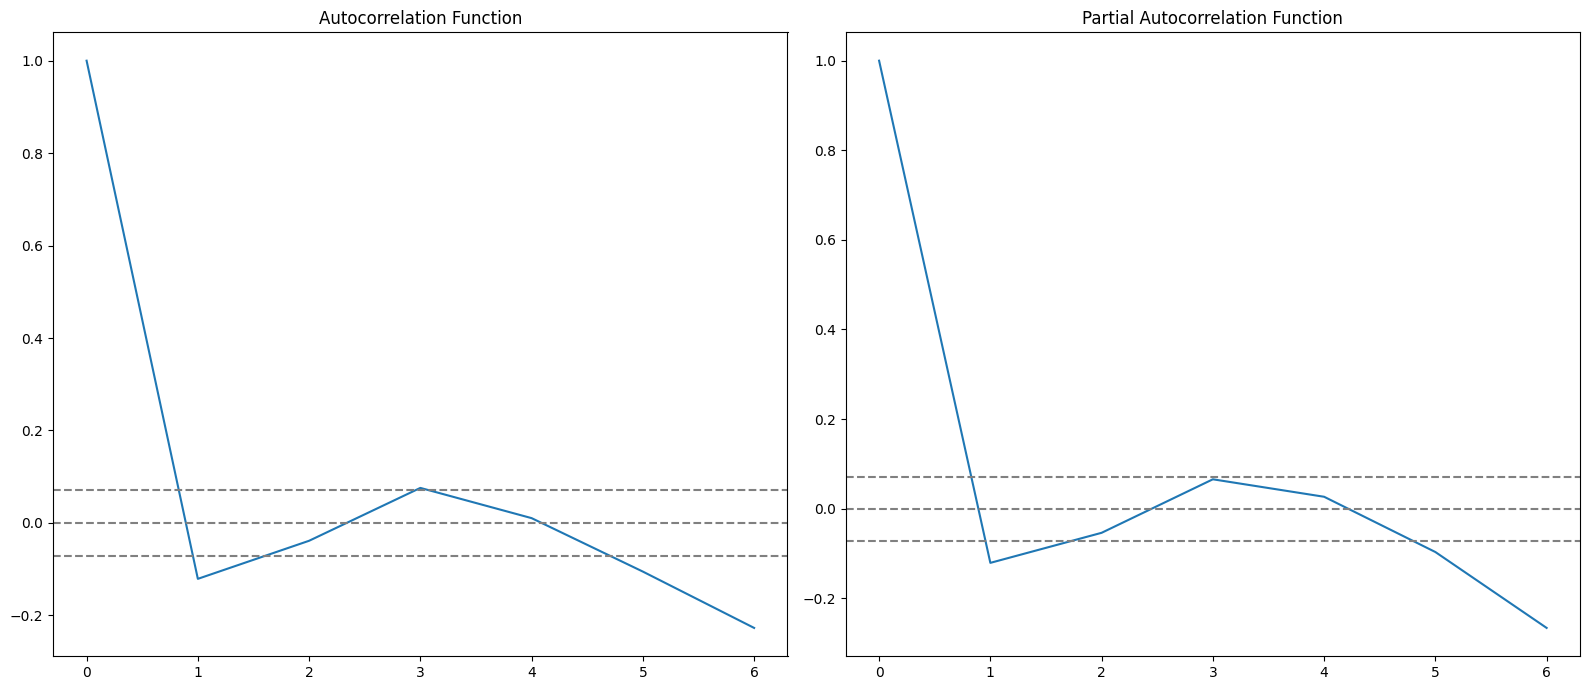

In [62]:
model_selector = ModelSelector(train_series)
model_selector.choose_order(max_ar=6, max_ma=6)

AR(p) and MA(q) = (1, 1) is appropriate according to the graph

#### ARIMA Model
##### Grid Search

In [81]:
# Initialize the ARIMA_fit class
arima_fitter = ARIMA_fit(train_series)

# Specify the range of parameters to try
p_values = range(0, 6)
d_values = range(0, 6)
q_values = range(0, 6)

# Fit the ARIMA models and find the best one
best_model_results = arima_fitter.grid_search(p_values, d_values, q_values)

Best ARIMA(2, 4, 2) model with AIC: 10.0


In [82]:
arima_results = ARIMA_fit(train_series)
model_results = arima_results.fit_model(order=(2, 4, 2))

C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qb

In [83]:
arima_forecaster = Forecaster(model_results)
arima_predicted_values, arima_conf_int = arima_forecaster.forecast(steps=len(test_series))
actual_values = test_series.values

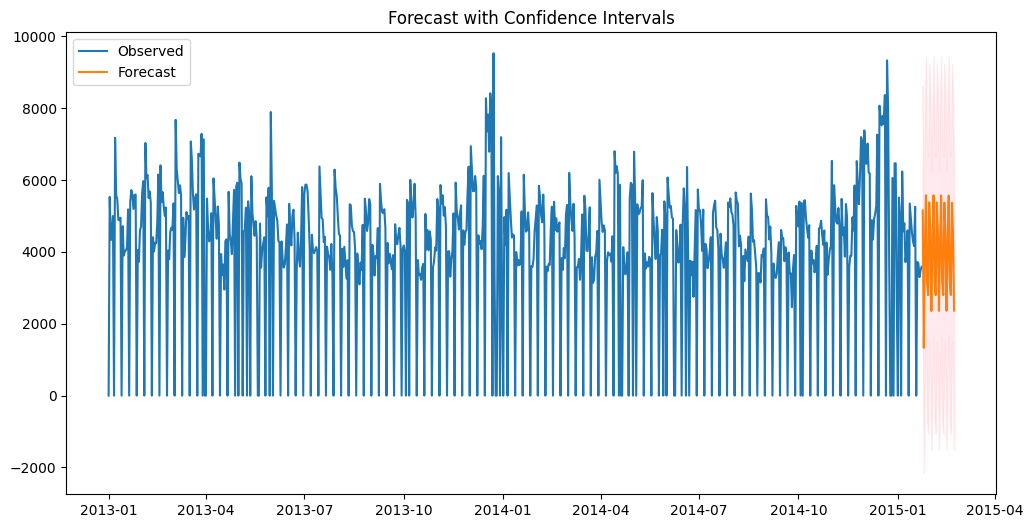

In [84]:
# Forecast future values and plot
arima_forecaster.plot_forecast(steps=30, series=train_series)

In [85]:
error_analysis = ErrorAnalysis(actual_values, arima_predicted_values)
error_report = error_analysis.report()

print(error_report)

{'MAE': 1328.850199963808, 'MSE': 2753529.956076418, 'RMSE': 1659.376375653341}


### SARIMA Model

##### Grid Search

In [73]:
import itertools

# Initialize the SARIMA_fit class
sarima_fitter = SARIMA_fit(train_series)

# Specify the range of parameters to try
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
seasonal_p_values = [0, 1, 2]
seasonal_d_values = [0, 1]
seasonal_q_values = [0, 1, 2]
seasonal_period = 12  # The seasonal period (e.g., 12 for monthly data)

# Generate all different combinations of pdq and seasonal pdq values
pdq_values = list(itertools.product(p_values, d_values, q_values))
seasonal_pdq_values = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(seasonal_p_values, seasonal_d_values, seasonal_q_values))]

# Perform grid search
best_order, best_seasonal_order = sarima_fitter.grid_search(pdq_values, seasonal_pdq_values)

Best SARIMA(2, 0, 2)x(2, 1, 2, 12) - AIC:12892.559827062078


C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [97]:
# Initialize the FitSARIMA class
sarima_fitter = SARIMA_fit(train_series)

# Fit the model
order = (2, 0, 2)  # Replace with your chosen values
seasonal_order = (2, 1, 2, 12)  # Replace with your chosen values
sarima_results = sarima_fitter.fit_model(order, seasonal_order)

C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Duy Nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [98]:
sarima_forecaster = Forecaster(sarima_results)
sarima_predicted_values, sarima_conf_int = sarima_forecaster.forecast(steps=len(test_series))
actual_values = test_series.values

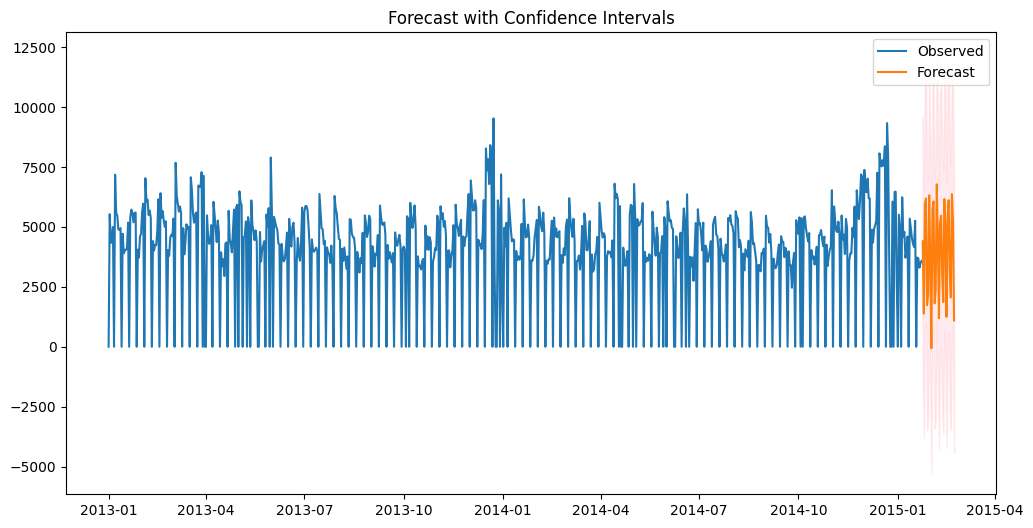

In [99]:
sarima_forecaster.plot_forecast(steps=30, series=train_series)

In [100]:
error_analysis = ErrorAnalysis(actual_values, sarima_predicted_values)
error_report = error_analysis.report()

print(error_report)

{'MAE': 1560.3901670772125, 'MSE': 3452270.0900763753, 'RMSE': 1858.0285493168224}


all the metrics for ARIMA model perform better